In [2]:
import pandas as pd

In [3]:
df=pd.read_csv('data\Retail_Dataset2.csv', parse_dates=['Date'])

In [4]:
df.head()

,Product_id,Product_Code,Warehouse,Product_Category,Date,Order_Demand,Open,Promo,StateHoliday,SchoolHoliday,Petrol_price
0,786725,Product_0033,Whse_S,Category_005,2016-01-03,16000,1,0,0,0,91
1,786743,Product_1825,Whse_S,Category_006,2016-01-03,50000,1,0,0,0,85
2,786967,Product_0551,Whse_S,Category_030,2016-01-03,3000,1,0,0,0,85
3,786856,Product_0556,Whse_S,Category_030,2016-01-03,1000,1,0,0,0,93
4,899538,Product_1844,Whse_A,Category_018,2016-01-03,7,1,0,0,0,95


In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

In [6]:
import numpy as np 
df['Order_Demand'] = df['Order_Demand'].clip(lower=0)  # Just in case
df['Order_Demand'] = np.log1p(df['Order_Demand'])  # log(1 + x)

In [7]:
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day
df['dayofweek'] = df['Date'].dt.dayofweek
df['is_weekend'] = df['dayofweek'].isin([5,6]).astype(int)


In [8]:
df['lag_1'] = df['Order_Demand'].shift(1)
df['rolling_mean_3'] = df['Order_Demand'].shift(1).rolling(3).mean()

In [9]:
df['lag_7'] = df['Order_Demand'].shift(7)
df['rolling_mean_7'] = df['Order_Demand'].shift(1).rolling(window=7).mean()
df['rolling_std_7'] = df['Order_Demand'].shift(1).rolling(window=7).std()


In [10]:
df = df.dropna(subset=['lag_1', 'rolling_mean_3','lag_7','rolling_mean_7','rolling_std_7'])

In [11]:
print(df[['lag_1', 'rolling_mean_3','lag_7','rolling_mean_7','rolling_std_7']].isnull().sum())
print(df['Product_id'].value_counts().head(10))  # Some IDs may only occur once or twice

lag_1             0
rolling_mean_3    0
lag_7             0
rolling_mean_7    0
rolling_std_7     0
dtype: int64
Product_id
899537     1
972379     1
975900     1
1025317    1
1033714    1
1022621    1
869375     1
1026792    1
1000798    1
986149     1
Name: count, dtype: int64


In [12]:
from sklearn.preprocessing import LabelEncoder

cat_cols = ['Product_Code', 'Warehouse', 'Product_Category', 'StateHoliday']

for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))


In [13]:
df['Open'] = df['Open'].astype(int)
df['Promo'] = df['Promo'].astype(int)
df['SchoolHoliday'] = df['SchoolHoliday'].astype(int)

In [14]:
features = [
    'Product_Code', 'Warehouse', 'Product_Category', 'Open', 'Promo',
    'StateHoliday', 'SchoolHoliday', 'Petrol_price',
    'year', 'month', 'day', 'dayofweek', 'is_weekend',
    'lag_1', 'rolling_mean_3'
]

X = df[features]
y = df['Order_Demand']

In [15]:
print("Start Date:", df['Date'].min())
print("End Date:", df['Date'].max())


Start Date: 2016-01-03 00:00:00
End Date: 2016-11-23 00:00:00


In [16]:
split_date = '2016-10-01'  # Last ~2 months used as test data

X_train = X[df['Date'] < split_date]
X_test = X[df['Date'] >= split_date]
y_train = y[df['Date'] < split_date]
y_test = y[df['Date'] >= split_date]

print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")


Train size: (140076, 15), Test size: (29128, 15)


In [17]:
from xgboost import XGBRegressor
model = XGBRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [18]:
y_pred = model.predict(X_test)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("R2 Score:", r2_score(y_test, y_pred))

MAE: 1.1458708330490164
RMSE: 1.5343136349262507
R2 Score: 0.7204301414225593


d:\ML\Forecast\venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [19]:
from catboost import CatBoostRegressor
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=8,
    l2_leaf_reg=5,
    loss_function='RMSE',
    eval_metric='R2',
    cat_features=cat_cols,
    verbose=100
)
model.fit(X_train, y_train)

0:	learn: 0.0534959	total: 276ms	remaining: 4m 35s
100:	learn: 0.7221330	total: 13.5s	remaining: 1m 59s
200:	learn: 0.7296896	total: 33.8s	remaining: 2m 14s
300:	learn: 0.7333377	total: 49.4s	remaining: 1m 54s
400:	learn: 0.7358067	total: 1m 6s	remaining: 1m 39s
500:	learn: 0.7382398	total: 1m 26s	remaining: 1m 26s
600:	learn: 0.7405885	total: 1m 42s	remaining: 1m 8s
700:	learn: 0.7428293	total: 1m 59s	remaining: 50.9s
800:	learn: 0.7444735	total: 2m 12s	remaining: 33s
900:	learn: 0.7467006	total: 2m 26s	remaining: 16.1s
999:	learn: 0.7488817	total: 2m 39s	remaining: 0us


In [20]:
y_pred = model.predict(X_test)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("R2 Score:", r2_score(y_test, y_pred))

MAE: 1.1119514389536622
RMSE: 1.4838365302827043
R2 Score: 0.7385225896101839


d:\ML\Forecast\venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# NEW FEATURE ENGG WITH FEATURE CREATION AND USING THE BEST MODEL CATBOOST

In [21]:
df['Date'] = pd.to_datetime(df['Date'])

df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['IsWeekend'] = (df['DayOfWeek'] >= 5).astype(int)
df.drop(columns='Date', inplace=True)

In [22]:
df.columns

Index(['Product_id', 'Product_Code', 'Warehouse', 'Product_Category',
       'Order_Demand', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday',
       'Petrol_price', 'year', 'month', 'day', 'dayofweek', 'is_weekend',
       'lag_1', 'rolling_mean_3', 'lag_7', 'rolling_mean_7', 'rolling_std_7',
       'Year', 'Month', 'Week', 'Day', 'DayOfWeek', 'IsWeekend'],
      dtype='object')

In [23]:
X = df.drop(columns=['Order_Demand'])  # drop datetime
y = df['Order_Demand']

In [24]:
X_encoded = pd.get_dummies(X, drop_first=True)

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)


In [26]:
from sklearn.model_selection import cross_val_score
from catboost import CatBoostRegressor

# Use the same config
final_model = CatBoostRegressor(verbose=0, n_estimators=200, learning_rate=0.1, depth=6)

# Perform 5-fold CV
cv_scores = cross_val_score(final_model, X_encoded, y, cv=5, scoring='r2')

# Output results
print(f"CatBoost Cross-Validation R² Scores: {cv_scores}")
print(f"Mean R² Score: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")

CatBoost Cross-Validation R² Scores: [0.72680592 0.71725412 0.72899646 0.72541581 0.72695335]
Mean R² Score: 0.7251
Standard Deviation: 0.0041


In [27]:
cat_features = ['Product_Code', 'Warehouse', 'Product_Category', 'StateHoliday']
model = CatBoostRegressor(verbose=100)
model.fit(X_train, y_train, cat_features=cat_features)


Learning rate set to 0.088911
0:	learn: 2.7684712	total: 74ms	remaining: 1m 13s
100:	learn: 1.4380861	total: 6.36s	remaining: 56.6s
200:	learn: 1.4068106	total: 13.8s	remaining: 54.8s
300:	learn: 1.3845165	total: 23.2s	remaining: 53.8s
400:	learn: 1.3693969	total: 30.7s	remaining: 45.9s
500:	learn: 1.3563365	total: 39s	remaining: 38.9s
600:	learn: 1.3455596	total: 48.4s	remaining: 32.2s
700:	learn: 1.3367967	total: 57.8s	remaining: 24.6s
800:	learn: 1.3284287	total: 1m 6s	remaining: 16.5s
900:	learn: 1.3203480	total: 1m 20s	remaining: 8.9s
999:	learn: 1.3124504	total: 1m 32s	remaining: 0us


In [28]:
y_pred=model.predict(X_test)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("R2 Score:", r2_score(y_test, y_pred))   

MAE: 0.9928722158661042
RMSE: 1.327061020909552
R2 Score: 0.7941521320682138


d:\ML\Forecast\venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [29]:
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor

# Define the param grid
param_grid = {
    'iterations': [500, 1000, 1500],
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'bagging_temperature': [0, 1, 2, 5],
    'random_strength': [1, 5, 10]
}

# Initialize model
model = CatBoostRegressor(verbose=0, cat_features=cat_cols)

# Hyperparameter tuning using randomized search
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=20,
    cv=3,
    scoring='r2',
    random_state=42,
    n_jobs=-1
)

# Fit
random_search.fit(X_train, y_train)

# Best model and score
print("Best Params:", random_search.best_params_)
print("Best R2 Score on Train:", random_search.best_score_)

# Predict on test
y_pred = random_search.best_estimator_.predict(X_test)

# Evaluate on test
from sklearn.metrics import r2_score
print("R2 Score on Test:", r2_score(y_test, y_pred))


Best Params: {'random_strength': 5, 'learning_rate': 0.2, 'l2_leaf_reg': 7, 'iterations': 1000, 'depth': 8, 'bagging_temperature': 0}
Best R2 Score on Train: 0.7951912162358806
R2 Score on Test: 0.803782027894349


In [33]:
param={'random_strength': 5, 
 'learning_rate': 0.2, 
 'l2_leaf_reg': 7, 
 'iterations': 1000, 
 'depth': 8, 
 'bagging_temperature': 1}

In [34]:
model= CatBoostRegressor(**param, verbose=100, cat_features=cat_cols)
model.fit(X_train, y_train)

0:	learn: 2.5622690	total: 114ms	remaining: 1m 54s
100:	learn: 1.3840812	total: 10.1s	remaining: 1m 30s
200:	learn: 1.3335993	total: 23.8s	remaining: 1m 34s
300:	learn: 1.3000865	total: 38.8s	remaining: 1m 30s
400:	learn: 1.2721215	total: 52.7s	remaining: 1m 18s
500:	learn: 1.2490839	total: 1m 10s	remaining: 1m 10s
600:	learn: 1.2249508	total: 1m 25s	remaining: 56.6s
700:	learn: 1.2031050	total: 1m 39s	remaining: 42.5s
800:	learn: 1.1824138	total: 1m 53s	remaining: 28.3s
900:	learn: 1.1637061	total: 2m 9s	remaining: 14.2s
999:	learn: 1.1461461	total: 2m 26s	remaining: 0us


In [32]:
y_pred=model.predict(X_test)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("R2 Score:", r2_score(y_test, y_pred))

MAE: 0.9596632382816549
RMSE: 1.2956482058173182
R2 Score: 0.803782027894349


d:\ML\Forecast\venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


d:\ML\Forecast\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


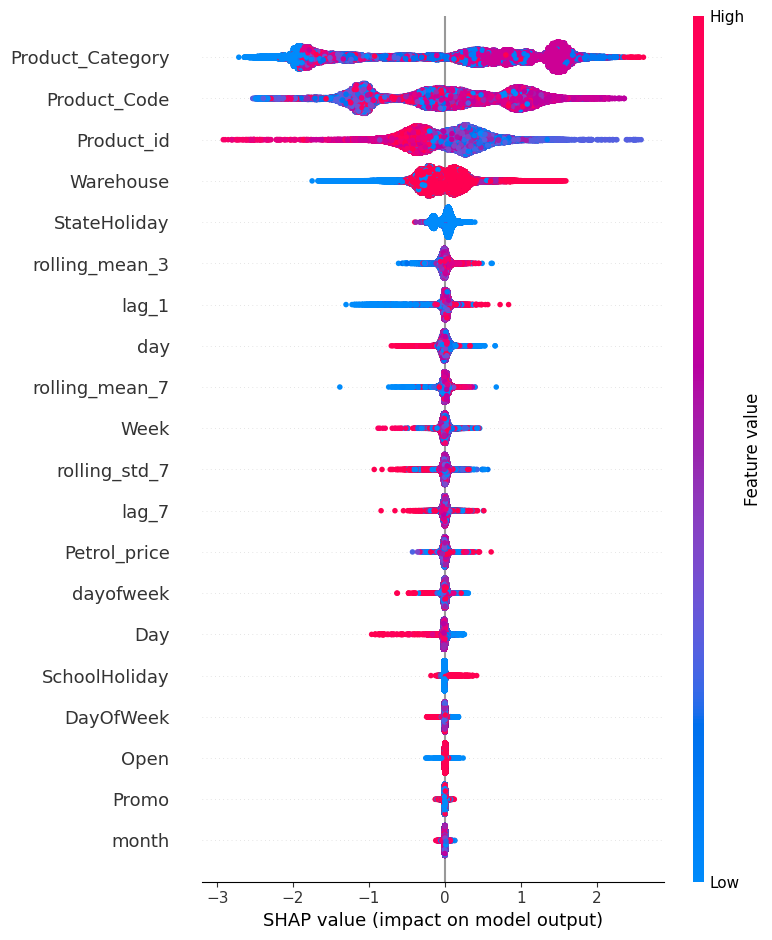

In [37]:
import shap
explainer = shap.Explainer(model)
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train)

In [38]:
df['Order'].max()

KeyError: 'Order'